Case 3
Jorma Männistö, Helsinki Metropolia University of Applied Sciences 
Last edited: 11.03.2018
The objective of this assignment is to build a recurrent neural network to categorize medical texts' abstracts in order to determine the wellbeing of the individual based on the words used in the abstracts.

In [3]:
# Download a local copy of the tar-file
from urllib.request import urlretrieve
url = "http://disi.unitn.it/moschitti/corpora/ohsumed-first-20000-docs.tar.gz"
dst = 'ohsumed-first-20000-docs.tar.gz'
urlretrieve(url, dst)

('ohsumed-first-20000-docs.tar.gz', <http.client.HTTPMessage at 0xb8c8259240>)

In [4]:
# Extract the .tar-file and create the folder
import tarfile
tar = tarfile.open("ohsumed-first-20000-docs.tar.gz")
tar.extractall()
tar.close()

In [72]:
import os
import time
ohsumed_dir = 'ohsumed-first-20000-docs'
train_dir = os.path.join(ohsumed_dir, 'training')

labels = []
texts = []

t1 = time.time()

# Generate a list L = ['C01', 'C02, ..., 'C023']
L = ['C{:02}'.format(n) for n in range(1, 23 + 1)]
for label_type in L:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        texts.append(f.read())
        f.close()
        i = L.index(label_type)
        labels.append(i)
t2 = time.time()
print('Time elapsed {:.0f} seconds.'.format((t2-t1)))

Time elapsed 3 seconds.


In [73]:
# Tokenizing text from raw data

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 300 # common length of the samples
max_words = 20000 # number of words which are used the most

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 30857 unique tokens


In [65]:
# Shaping and shuffling the data and the labels

from keras.utils.np_utils import to_categorical

data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
one_hot_labels = to_categorical(labels)


print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', one_hot_labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
one_hot_labels = one_hot_labels[indices]

Shape of data tensor: (10433, 300)
Shape of labels tensor: (10433, 23)


In [74]:
# Building the model

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, SimpleRNN, Dropout

model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(SimpleRNN(8))
# model.add(LSTM(100)) another method by Kopu
model.add(Dense(1024, activation = 'relu'))
#model.add(Dropout(0.3))
model.add(Dense(256, activation = 'relu'))
#model.add(Dropout(0.3))
model.add(Dense(len(L), activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 300, 32)           640000    
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 8)                 328       
_________________________________________________________________
dense_31 (Dense)             (None, 1024)              9216      
_________________________________________________________________
dense_32 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_33 (Dense)             (None, 23)                5911      
Total params: 917,855
Trainable params: 917,855
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Training the model

import time

t1 = time.time()
history = model.fit(data, one_hot_labels,
                   epochs = 20,
                   batch_size = 32,
                   validation_split = 0.2)
t2 = time.time()
print('Elapsed time: {:.2f} seconds'.format((t2-t1)))

Train on 8346 samples, validate on 2087 samples
Epoch 1/20
8346/8346 [==============================] - 35s 4ms/step - loss: 2.7943 - acc: 0.1707 - val_loss: 2.7074 - val_acc: 0.1739
Epoch 2/20
8346/8346 [==============================] - 32s 4ms/step - loss: 2.6063 - acc: 0.2097 - val_loss: 2.6831 - val_acc: 0.1917
Epoch 3/20
8346/8346 [==============================] - 32s 4ms/step - loss: 2.3463 - acc: 0.2779 - val_loss: 2.8412 - val_acc: 0.1624
Epoch 4/20
8346/8346 [==============================] - 32s 4ms/step - loss: 2.1019 - acc: 0.3456 - val_loss: 3.0194 - val_acc: 0.1327
Epoch 5/20
8346/8346 [==============================] - 31s 4ms/step - loss: 1.9075 - acc: 0.3942 - val_loss: 3.1998 - val_acc: 0.1203
Epoch 6/20
8346/8346 [==============================] - 30s 4ms/step - loss: 1.7555 - acc: 0.4412 - val_loss: 3.3455 - val_acc: 0.1021
Epoch 7/20
8346/8346 [==============================] - 30s 4ms/step - loss: 1.6190 - acc: 0.4705 - val_loss: 3.6511 - val_acc: 0.0954
Epoch 8

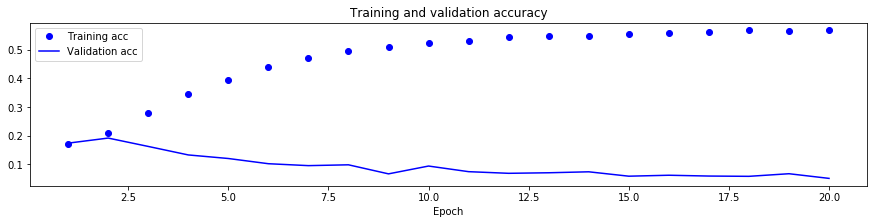

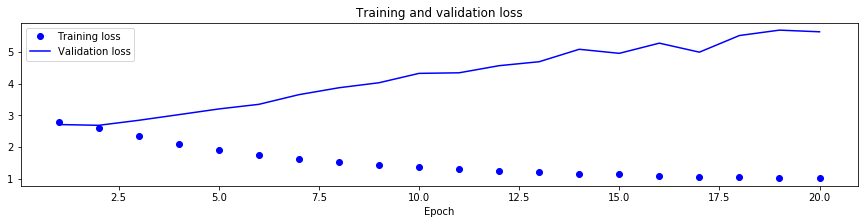

In [76]:
# Training results

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 3))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.legend()


plt.figure(figsize=(15, 3))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

Metrics results

In [77]:
# Calculate the predictions
predictions = model.predict(data)
y_pred = np.argmax(predictions, axis = 1)

In [78]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
# Classification results per class
print(classification_report(labels, y_pred))

             precision    recall  f1-score   support

          0       0.05      0.07      0.06       423
          1       0.01      0.01      0.01       158
          2       0.00      0.00      0.00        65
          3       0.11      0.09      0.10      1163
          4       0.02      0.02      0.02       283
          5       0.05      0.07      0.06       588
          6       0.00      0.00      0.00       100
          7       0.05      0.06      0.06       473
          8       0.00      0.00      0.00       125
          9       0.06      0.05      0.05       621
         10       0.04      0.04      0.04       162
         11       0.06      0.07      0.06       491
         12       0.03      0.04      0.04       281
         13       0.12      0.11      0.11      1249
         14       0.01      0.01      0.01       215
         15       0.03      0.05      0.04       200
         16       0.02      0.01      0.02       295
         17       0.02      0.03      0.03   

In [70]:
# Confusion matrix
cm = confusion_matrix(labels, y_pred)
print(np.array2string(cm, max_line_width = 120))

[[226  11   4   8   6  11   1  15   0   5   6   8   3  16   8   0   1   5   0  37  14   3  35]
 [  8  62   3  11   2   0   1   4   1   3   0   0   4   4   2   0   2   1   0  41   0   1   8]
 [  2   0  35   0   0   2   0   1   0   2   3   1   0   3   1   1   0   1   0   9   0   2   2]
 [  5   4   3 684   9  37  12  43   7  28   9  66  29  28  16   9  11  18  36  31   7   0  71]
 [  7   1   5   5 147   6   2   3   0   5   1   1   0   6   8   4  17   3   3   5  22   1  31]
 [ 30   6   0  52   3 328   0  14   0  12   0   8   7   8   9   3   1   9   3  13  11   2  69]
 [  3   2   0  14   3   0  50   1   2   0   0   1   0   1   1   0   4   1   0   5   2   0  10]
 [ 21   3   4  39   3   8   2 235  10   8   1   7   4  18  15   4   0   1   1  41  15   4  29]
 [  3   2   0  17   4   0   0  11  58   1   2   1   1   0   3   1   1   0   1   6   1   0  12]
 [ 18   4   5  26  10  14   0   7   1 354  10   8   4  19   6   1   2   3   7  23  17   5  77]
 [  4   3   5   8   2   1   0   0   0   7  85   0 

True class:  1
Predicted class: 12
Predictions per class:
[  7.33e-03   6.15e-04   2.98e-05   1.29e-01   2.00e-02   1.08e-01
   6.21e-02   7.81e-03   3.29e-02   1.81e-02   4.56e-04   5.94e-02
   1.70e-01   1.19e-02   1.02e-01   1.59e-01   7.06e-03   1.23e-03
   1.63e-02   3.30e-03   4.06e-04   1.43e-04   8.23e-02]


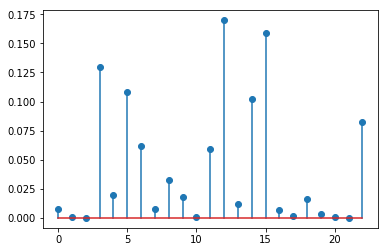

In [79]:
print('True class: ', labels[512])
print('Predicted class:', y_pred[512])
print('Predictions per class:')
print(np.array2string(predictions[512], precision = 2))

plt.stem(predictions[512])
plt.show()

Conclusions

As can be seen above from the, the results are fairly abysmal with training accuracy approaching ~55 % and validation accuracy declining steadily from ~20 % whilst validation loss keeps going higher. As such, no conclusive results to the patients' wellbeing should be based on this model. In order to improve the results dropout -layers were implemented to the model. This however didn't noticeably (if at all) improve the results.